In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare and save ADNI file

In [252]:
# Load data
adni_data = pd.read_csv('data/mainfile.csv', low_memory=False)
adni_data.head()

,RID,DIAG,Phase,ID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,PTSOURCE,...,PREV_DIAG,DIAG_CHANGED,DIAG_GROUP,PATIENT_FIRST_DIAG,PATIENT_LAST_DIAG,PATIENT_DIAG_GROUP,PATIENT_DIAG_CHANGED,NEXT_DIAG,NEXT_DIAG_CHANGE,NEXT_DIAG_GROUP
0,2,NL,ADNI1,18.0,107.0,sc,sc,2005-08-17,NaN,Participant Visit,...,NL,False,NL-NL,NL,MCI,NL-MCI,True,NL,False,NL-NL
1,2,NL,ADNI1,18.0,107.0,sc,bl,2005-08-17,NaN,Participant Visit,...,NL,False,NL-NL,NL,MCI,NL-MCI,True,NL,False,NL-NL
2,2,NL,ADNI1,18.0,107.0,sc,m06,2005-08-17,NaN,Participant Visit,...,NL,False,NL-NL,NL,MCI,NL-MCI,True,NL,False,NL-NL
3,2,NL,ADNI1,18.0,107.0,sc,m36,2005-08-17,NaN,Participant Visit,...,NL,False,NL-NL,NL,MCI,NL-MCI,True,NL,False,NL-NL
4,3,AD,ADNI1,22.0,107.0,sc,sc,2005-08-18,NaN,Participant Visit,...,AD,False,AD-AD,AD,AD,AD-AD,False,AD,False,AD-AD


In [253]:
# Add id
adni_data['UID'] = adni_data['RID'].astype(str) + '_' + adni_data['VISCODE2'].astype(str)

In [254]:
# Drop NA
csf_cols = ['UID', 'RID', 'VISCODE2', 'ABETA', 'TAU', 'PTAU', 'DIAG']

print('Number of rows before dropping NA: {}'.format(adni_data.shape[0]))
adni_data = adni_data.dropna(subset=csf_cols)
print('Number of rows after dropping NA: {}'.format(adni_data.shape[0]))

Number of rows before dropping NA: 18200
Number of rows after dropping NA: 8892


In [255]:
# Drop duplicates
print('Number of rows before dropping duplicates: {}'.format(adni_data.shape[0]))
adni_data = adni_data.drop_duplicates(subset=['UID'])
print('Number of rows after dropping duplicates: {}'.format(adni_data.shape[0]))

Number of rows before dropping duplicates: 8892
Number of rows after dropping duplicates: 8377


In [256]:
# Save data
adni_data.to_csv('data/ADNI.csv', index=False)

## Extract CSF data

In [257]:
# CSF data
csf_data = adni_data[csf_cols]

# Define DIAG as category of order NL, MCI, AD
csf_data.loc[:, 'DIAG'] = pd.Categorical(csf_data['DIAG'], ordered=True, categories=['NL', 'MCI', 'AD'])

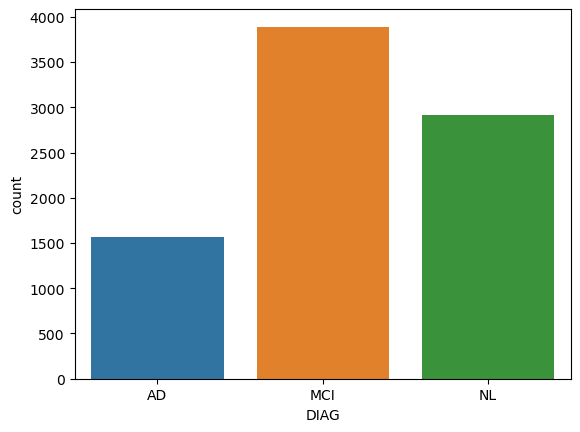

In [258]:
# Plot Histogram of Diagnosis
sns.countplot(x='DIAG', data=csf_data)
plt.show()

In [259]:
# Standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
csf_data.loc[:, ['ABETA', 'TAU', 'PTAU']] = scaler.fit_transform(csf_data[['ABETA', 'TAU', 'PTAU']])

## Logistic Regression Model

In [260]:
# Train Logic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score

# Split data into train and test sets
X = csf_data[['ABETA', 'TAU', 'PTAU']]
y = csf_data['DIAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model using GridSearchCV
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred, average='macro')))

Accuracy: 0.48568019093078757
Precision: 0.49392894632228607


In [261]:
# Train LogisticRegression using GridSearchCV 
# param_grid={'penalty': ['l2', 'l1', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10]}
from sklearn.model_selection import GridSearchCV

# Train model using GridSearchCV
grid = GridSearchCV(LogisticRegression(), param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [10000]})
res = grid.fit(X_train, y_train)

print('Best params: {}'.format(res.best_params_))

# Evaluate model
model = res.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred, average='macro')))

Best params: {'C': 0.001, 'max_iter': 10000, 'penalty': 'l2'}
Accuracy: 0.4880668257756563
Precision: 0.5159765752177012


In [262]:
# Save prediction of best model as a new column in csf_data
csf_data.loc[:, 'DIAG_PRED_LR'] = model.predict(csf_data[['ABETA', 'TAU', 'PTAU']]).copy()
csf_data.loc[:, 'DIAG_PRED_LR'] = pd.Categorical(csf_data['DIAG_PRED_LR'], ordered=True, categories=['NL', 'MCI', 'AD'])

/var/folders/8s/7zgyk05565q9l208ztk8spw80000gn/T/ipykernel_6580/1831306272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csf_data.loc[:, 'DIAG_PRED_LR'] = model.predict(csf_data[['ABETA', 'TAU', 'PTAU']]).copy()


## Decision Tree Model

In [263]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Train model using GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(), param_grid={'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [2, 5, 18]})
res = grid.fit(X_train, y_train)

print('Best params: {}'.format(res.best_params_))

# Evaluate model
model = res.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred, average='macro')))

Best params: {'criterion': 'gini', 'max_depth': 18}
Accuracy: 0.9630071599045346
Precision: 0.9595250996433874


In [264]:
# Save prediction of best model as a new column in csf_data
csf_data.loc[:, 'DIAG_PRED_DT'] = model.predict(csf_data[['ABETA', 'TAU', 'PTAU']]).copy()
csf_data.loc[:, 'DIAG_PRED_DT'] = pd.Categorical(csf_data['DIAG_PRED_DT'], ordered=True, categories=['NL', 'MCI', 'AD'])

/var/folders/8s/7zgyk05565q9l208ztk8spw80000gn/T/ipykernel_6580/1232592718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csf_data.loc[:, 'DIAG_PRED_DT'] = model.predict(csf_data[['ABETA', 'TAU', 'PTAU']]).copy()


## Save to CSV

In [268]:
# Save csf_data to CSV
csf_data.to_csv('data/ADNI_PRED.csv', index=False)

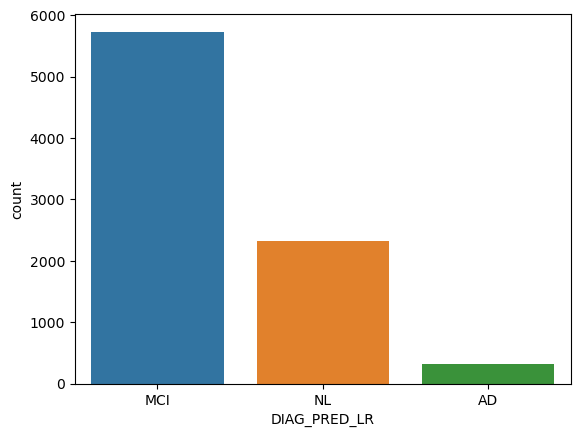

In [269]:
# Plot Histogram of Diagnosis
sns.countplot(x='DIAG_PRED_LR', data=csf_data)
plt.show()

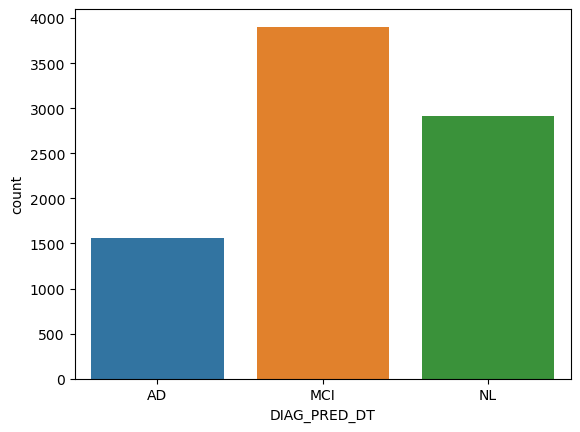

In [270]:
# Plot Histogram of Diagnosis
sns.countplot(x='DIAG_PRED_DT', data=csf_data)
plt.show()